In [ ]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import matplotlib.gridspec as gridspec
from sunpy.map import Map
from astropy.visualization import ImageNormalize, AsinhStretch

from torchmetrics import MeanAbsoluteError
from torchmetrics.regression import PearsonCorrCoef
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from img2img.data.preprocess.sdo.preprocess_aia import NormalizeEditor
def denorm(x):
    x = NormalizeEditor(0, 14).inverse(x)
    return x

def norm(x):
    x = NormalizeEditor(0, 14).call(x)
    return x

class fake_dir:
    def __init__(self, name, path):
        self.name = name
        self.path = path

def get_mask_within_disk(smap, margin=100):
    Y, X = np.ogrid[:smap.data.shape[0], :smap.data.shape[1]]
    xc, yc = smap.wcs.world_to_pixel(smap.center)
    dist = np.sqrt((X-xc)**2 + (Y-yc)**2)
    mask = dist <= smap.meta['r_sun'] - margin  # Mask points inside the circle
    return mask

def get_random_coord_within_disk(smap, margin=100):
    mask = get_mask_within_disk(smap, margin)
    x_indices, y_indices = np.where(mask == 1)
    coordinates_within_disk = np.array(list(zip(x_indices, y_indices)))
    coord_idx = np.random.choice(coordinates_within_disk.shape[0], 1)
    coord = coordinates_within_disk[coord_idx].flatten()
    return coord

class ImageManager:
    def __init__(self, x, y, w, h, edgecolor="black", linewidth=2):
        self.x, self.y, self.w, self.h = x, y, w, h
        self.xmin, self.xmax = x, x+w
        self.ymin, self.ymax = y, y+h
        self.edgecolor = edgecolor
        self.linewidth = linewidth
    
    def add_image(self, ax, ax_zoom, map, title, cmap, norm):
        x, y, w, h = self.x, self.y, self.w, self.h
        xmin, xmax = self.xmin, self.xmax
        ymin, ymax = self.ymin, self.ymax
        edgecolor = self.edgecolor
        linewidth = self.linewidth

        ax.imshow(map.data, cmap=cmap, origin="lower", norm=norm)
        ax.set_title(title)
        ax.add_patch(plt.Rectangle((xmin, ymin), w, h, edgecolor=edgecolor, facecolor="none", lw=linewidth))

        ax_zoom.imshow(map.data[ymin:ymax, xmin:xmax], cmap=cmap, origin="lower", norm=norm)
        con = ConnectionPatch(xyA=(xmin, ymax-1), xyB=(0, h-1), coordsA="data", coordsB="data", axesA=ax, axesB=ax_zoom,
                            color=edgecolor, lw=linewidth)
        ax_zoom.add_artist(con)
        con = ConnectionPatch(xyA=(xmax, ymax-1), xyB=(w-1, h-1), coordsA="data", coordsB="data", axesA=ax, axesB=ax_zoom,
                            color=edgecolor, lw=linewidth)
        ax_zoom.add_artist(con)

norm171 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.02))
norm304 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.005))
norm193 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.04))

In [ ]:
class Evaluator:
    def __init__(self, real_root, fake_roots, stage="test"):
        self.real_root = real_root
        self.fake_roots = fake_roots
        self.stage = stage

        real_root = Path(real_root) / stage
        real_input_root = real_root / "input"
        self.real_target_root = real_root / "target"
        self.real_input_files = sorted(real_input_root.glob("*.npz"))
        self.n = len(self.real_input_files)
        print(f"Found {self.n} files")

    def get_idx(self):
        idx = np.random.randint(0, self.n)
        self.idx = idx
        return self.idx

    def load_data(self, idx=None):
        if idx is not None:
            self.idx = idx
        real_input_files = self.real_input_files
        real_target_root = self.real_target_root
        fake_roots = self.fake_roots
        stage = self.stage

        real_input_file = real_input_files[idx]
        timestamp = real_input_file.stem[:19]
        self.timestamp_str = timestamp[:10] + timestamp[10:].replace("-", ":")

        real_target_files = sorted(real_target_root.glob("*.npz"))
        real_target_file = real_target_files[idx]
        assert real_target_file.stem[:19] == timestamp

        real_input = np.load(real_input_file, allow_pickle=True)
        real_inputs = [Map(data, meta) for data, meta in zip(real_input["data"], real_input["metas"])]
        real_input_map_171 = real_inputs[0]
        real_input_map_304 = real_inputs[1]
        real_input_map_171 = denorm(real_input_map_171)
        real_input_map_304 = denorm(real_input_map_304)

        real_target = np.load(real_target_file, allow_pickle=True)
        real_target_map = Map(real_target["data"][0], real_target["metas"][0])
        real_target_map = denorm(real_target_map)

        fake_target_map_list = []
        for k in range(len(fake_roots)):
            fake_target_files = sorted((fake_roots[k].path/stage).glob("*.npz"))
            print(fake_target_files)
            fake_target_file = fake_target_files[idx]
            assert fake_target_file.stem[:19] == timestamp

            fake_target = np.load(fake_target_file, allow_pickle=True)
            fake_target_map = Map(fake_target["data"][0], fake_target["metas"][0])
            fake_target_map = denorm(fake_target_map)
            fake_target_map_list.append(fake_target_map)

        self.real_input_map_171 = real_input_map_171
        self.real_input_map_304 = real_input_map_304
        self.real_target_map = real_target_map
        self.fake_target_map_list = fake_target_map_list

        self.timestamp = timestamp
        return self.timestamp

    def get_coord(self, w=100, h=None):
        real_target_map = self.real_target_map
        w = 100
        h = w if h is None else h
        self.w, self.h = w, h
        coord = get_random_coord_within_disk(real_target_map, margin=w)
        return coord
    
    def plot(self, coord, w=None, h=None, fontsize=15, yp=1.01, figsize=(3,8), hs=0.1, ws=0.1):
        plt.rcParams["font.size"] = fontsize

        x = coord[0]
        y = coord[1]
        self.x, self.y = x, y
        if w is not None:
            self.w = w
        if h is not None:
            self.h = h
        w = self.w
        h = self.h

        edgecolor="black"
        linewidth=1

        image_manager = ImageManager(x, y, w, h, edgecolor, linewidth)

        nrows = 2
        ncols = 3 + len(self.fake_roots)

        fig = plt.figure(figsize=(figsize[0]*ncols, figsize[1]))
        gs = gridspec.GridSpec(nrows, ncols)

        for i in range(ncols):
            ax = fig.add_subplot(gs[0, i])
            ax.set_aspect('equal')
            # ax.axis('off')
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            ax_zoom = fig.add_subplot(gs[1, i])
            ax_zoom.set_aspect('equal')
            # ax_zoom.axis('off')
            ax_zoom.axes.get_xaxis().set_visible(False)
            ax_zoom.axes.get_yaxis().set_visible(False)

            if i == 0:
                image_manager.add_image(ax, ax_zoom, self.real_input_map_171, "Input $171 \AA$", "sdoaia171", norm171)
            elif i == 1:
                image_manager.add_image(ax, ax_zoom, self.real_input_map_304, "Input $304 \AA$", "sdoaia304", norm304)
            elif i == 2:
                image_manager.add_image(ax, ax_zoom, self.real_target_map, "Target $193 \AA$", "sdoaia193", norm193)
            else:
                image_manager.add_image(ax, ax_zoom, self.fake_target_map_list[i-3], self.fake_roots[i-3].name, "sdoaia193", norm193)

        fig.suptitle(self.timestamp_str, y=yp)
        # fig.tight_layout()
        fig.subplots_adjust(hspace=hs, wspace=ws)
        plt.show()
        return fig
    
    def save(self, fig, suffix=""):
        idx = self.idx
        timestamp = self.timestamp
        x, y, w, h = self.x, self.y, self.w, self.h
        fig.savefig(f"{timestamp}_idx-{idx}_xy-{x}_{y}_wh-{w}_{h}{suffix}.png", bbox_inches="tight", pad_inches=0.1, dpi=600)

    def save_input_output(self):
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(self.real_input_map_171.data, cmap="sdoaia171", origin="lower", norm=norm171)
        ax.axis("off")
        fig.savefig(f"{self.timestamp}_real_input_map_171.png", bbox_inches="tight", pad_inches=0, dpi=300)

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(self.real_input_map_304.data, cmap="sdoaia304", origin="lower", norm=norm304)
        ax.axis("off")
        fig.savefig(f"{self.timestamp}_real_input_map_304.png", bbox_inches="tight", pad_inches=0, dpi=300)

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(self.real_target_map.data, cmap="sdoaia193", origin="lower", norm=norm193)
        ax.axis("off")
        fig.savefig(f"{self.timestamp}_real_target_map_193.png", bbox_inches="tight", pad_inches=0, dpi=300)
        plt.close("all")

In [ ]:
# fake_roots = [
#     fake_dir("pix2pix", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\pix2pix\unet_patchgan_1024_small\version_0")),
#     fake_dir("pix2pixHD", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\pix2pixHD\default_small\version_0")),
#     fake_dir("pix2pixCC", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\pix2pixCC\default_small\version_0")),
#     fake_dir("DDPM ($x_0$)", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\ddpm_x0\version_0")),
#     fake_dir("Fast-DDPM ($x_0$)", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\fast_ddpm_x0\version_0")),
#     fake_dir("DDPM ($\epsilon$)", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\ddpm_noise\version_0")),
#     fake_dir("Fast-DDPM ($\epsilon$)", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\fast_ddpm_noise\version_0")),
# ]

# fake_roots_ema = [
#     fake_dir("pix2pix\nEMA", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\pix2pix\unet_patchgan_1024_small_ema\version_0")),
#     fake_dir("pix2pixHD\nEMA", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\pix2pixHD\default_small_ema\version_0")),
#     fake_dir("pix2pixCC\nEMA", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\pix2pixCC\default_small_ema\version_0")),
#     fake_dir("DDPM ($x_0$)\nEMA", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\ddpm_x0_ema\version_0")),
#     fake_dir("Fast-DDPM ($x_0$)\nEMA", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\fast_ddpm_x0_ema\version_0")),
#     fake_dir("DDPM ($\epsilon$)\nEMA", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\ddpm_noise_ema\version_0")),
#     fake_dir("Fast-DDPM ($\epsilon$)\nEMA", Path(r"E:\home\mgjeon\image-to-image\metrics_old\sdo\diffusion\fast_ddpm_noise_ema\version_0")),
# ]

In [ ]:
fake_roots = [
    fake_dir("pix2pix", Path("D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out")),
    fake_dir("pix2pixHD", Path("D:/workspace/image-to-image/results/sdo/gan/pix2pixhd/logs/version_0/eval/last_99/out")),
    fake_dir("pix2pixCC", Path("D:/workspace/image-to-image/results/sdo/gan/pix2pixcc/logs/version_0/eval/last_99/out")),
    fake_dir("DDPM ($x_0$)", Path("D:/workspace/image-to-image/results/sdo/diffusion/ddpm/x0/logs/version_0/eval/last_99_timesteps=10/out")),
    # fake_dir("Fast-DDPM ($x_0$)", Path("D:/workspace/image-to-image/results/sdo/diffusion/fast_ddpm/x0/logs/version_0/eval/last_99_timesteps=10/out")),
    fake_dir("DDPM ($\epsilon$)", Path("D:/workspace/image-to-image/results/sdo/diffusion/ddpm/noise/logs/version_0/eval/last_99_timesteps=10/out")),
    fake_dir("Fast-DDPM ($\epsilon$)", Path("D:/workspace/image-to-image/results/sdo/diffusion/fast_ddpm/noise/logs/version_0/eval/last_99_timesteps=10/out")),
]

In [ ]:
eval = Evaluator(
    real_root="D:/workspace/image-to-image/data/aia_dataset",
    fake_roots=fake_roots,
    stage="test"
)

Found 244 files


In [ ]:
idx = eval.get_idx()
print(idx)

82


In [ ]:
# timestamp = eval.load_data(idx)
timestamp = eval.load_data(99)
print(timestamp)

[WindowsPath('D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out/test/2020-09-01T00-00-00_193_fake.npz'), WindowsPath('D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out/test/2020-09-02T00-00-00_193_fake.npz'), WindowsPath('D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out/test/2020-09-03T00-00-00_193_fake.npz'), WindowsPath('D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out/test/2020-09-04T00-00-00_193_fake.npz'), WindowsPath('D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out/test/2020-09-05T00-00-00_193_fake.npz'), WindowsPath('D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out/test/2020-09-06T00-00-00_193_fake.npz'), WindowsPath('D:/workspace/image-to-image/results/sdo/gan/pix2pix/logs/version_0/eval/last_99/out/test/2020-09-07T00-00-00_193_fake.npz'), WindowsPath('D:/workspace/image-t

In [ ]:
coord = eval.get_coord()
print(coord)

[713 342]


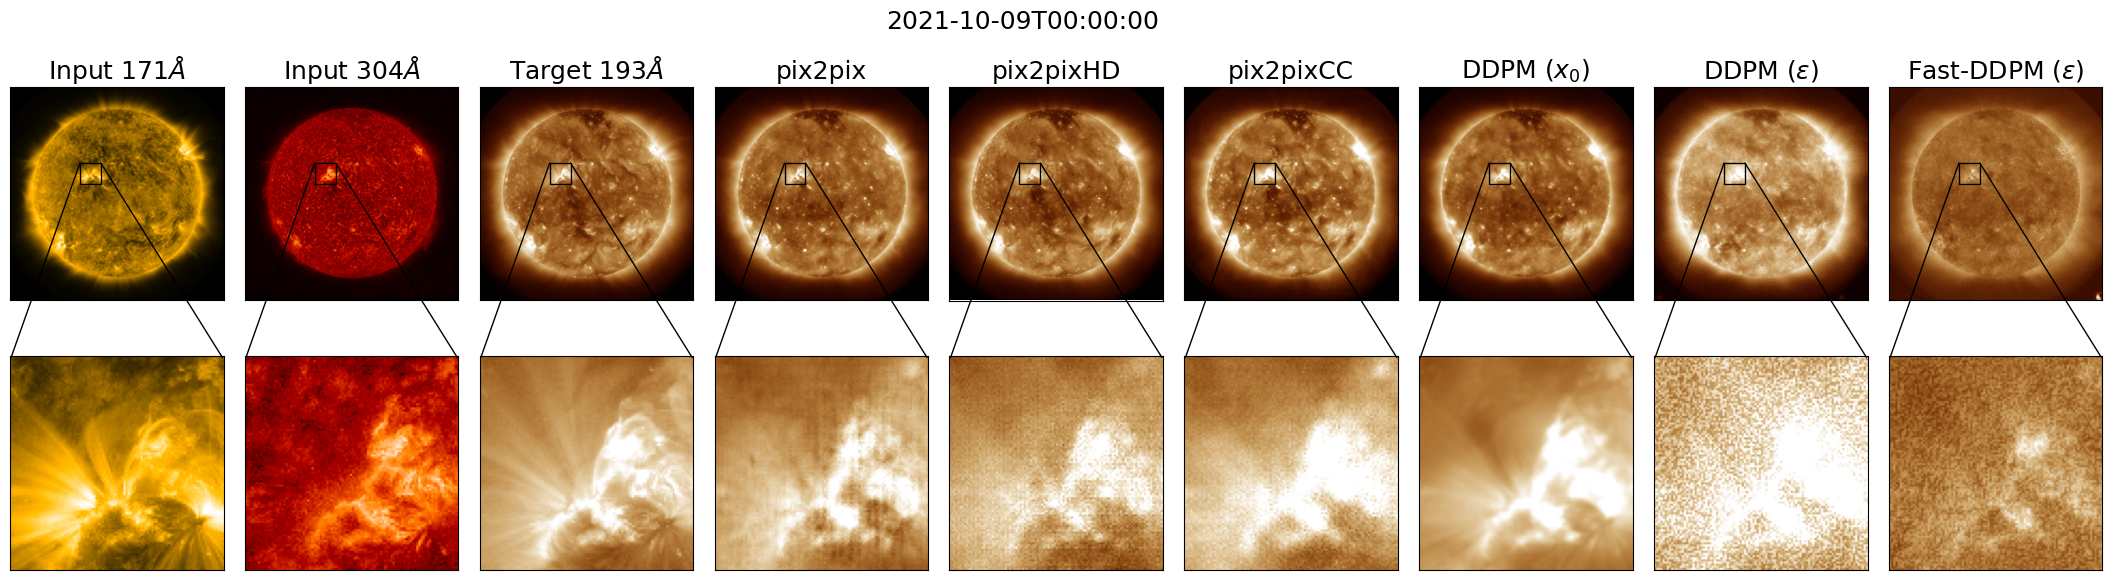

In [ ]:
# fig = eval.plot(coord)
fig = eval.plot((335, 560), w=100, h=100, yp=0.95, hs=0, figsize=(3, 7))

In [ ]:
eval.save(fig)

Found 244 files


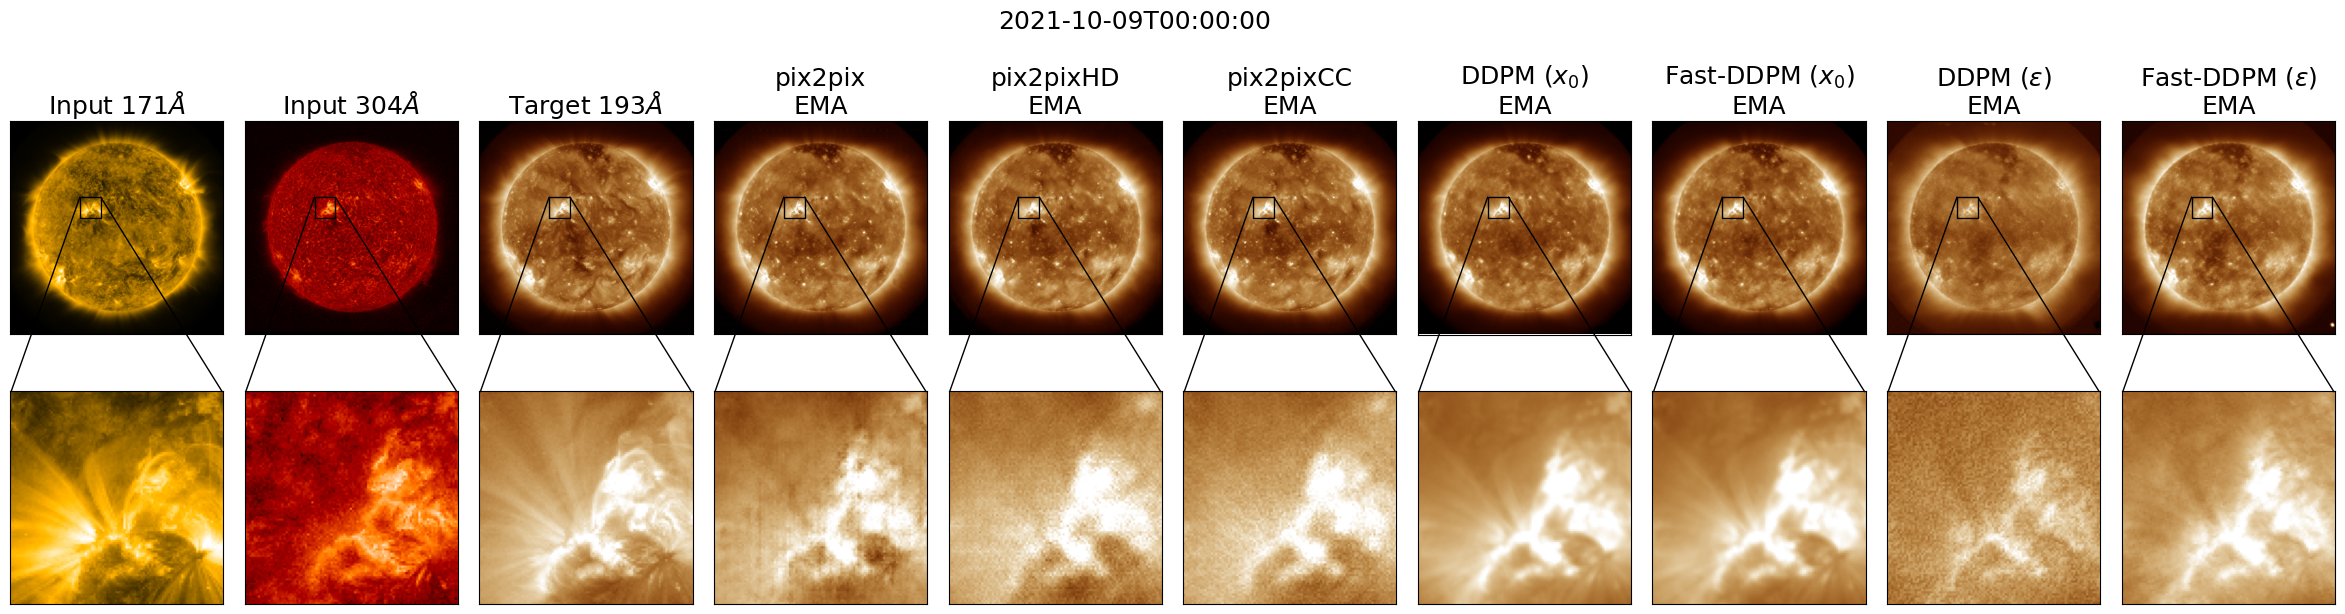

In [ ]:
eval = Evaluator(
    real_root="D:/data/aia_dataset",
    fake_roots=fake_roots_ema,
    stage="test"
)
eval.load_data(99)
fig = eval.plot((335, 560), w=100, h=100, yp=1, hs=0, figsize=(3, 7))
eval.save(fig, suffix="_ema")

In [ ]:
eval.save_input_output()